In [467]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer

import os; import sys
sys.path.append('/home/mitch/school/mfl/src/')
import utils
import sys; sys.path.append('/home/mitch/util/python')

In [468]:
from statsmodels.genmod.families.links import probit, identity

In [469]:
raw     = '/home/mitch/Dropbox/data/mexico_fls/raw/2005/'
processed = '/home/mitch/Dropbox/data/mexico_fls/processed2/'

figs    = '/home/mitch/school/mfl/fig/'
dicts   = '/home/mitch/school/mfl/notebooks/dicts/'

In [470]:
df = pd.read_csv(processed + 'data.csv')
df

,hhid,hhmember,weight_ind,is_hhm,age,attended_school,education,gender,income_type,income_undetailed,...,hh_has_savings_credit_institution,hh_has_savings_batch,hh_has_savings_person_not_hhm,hh_has_savings_afores,hh_has_savings_solidarity,hh_has_savings_at_house,hh_has_savings_other,hh_has_debts_12mth,hh_debts_12mth,hh_has_savings
0,1000,1,2244.0,1.0,41.0,True,Medium,Male,dk,NaN,...,False,False,False,False,False,False,False,0.0,0.0,False
1,3000,1,2244.0,1.0,45.0,False,Low,Male,undetailed,6000.0,...,False,False,False,False,False,False,False,0.0,0.0,False
2,8000,1,2244.0,1.0,33.0,True,High,Male,undetailed,60000.0,...,True,False,False,False,False,False,False,1.0,15000.0,True
3,10000,1,2074.0,1.0,39.0,True,Low,Female,NaN,NaN,...,False,False,False,False,False,False,False,1.0,5000.0,False
4,11000,1,2074.0,1.0,29.0,True,Medium,Male,detailed,NaN,...,False,False,False,False,False,False,False,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5058,10751000,1,5539.0,1.0,39.0,True,Low,Male,undetailed,5000.0,...,False,False,False,False,False,False,False,1.0,12000.0,False
5059,10752000,1,1614.0,1.0,32.0,True,Medium,Male,undetailed,60000.0,...,False,False,False,False,False,False,False,1.0,7000.0,False
5060,10754000,1,817.0,1.0,43.0,True,Low,Male,undetailed,59000.0,...,False,False,False,False,False,False,False,1.0,1500.0,False
5061,10758000,1,839.0,1.0,27.0,True,Low,Male,undetailed,36000.0,...,False,False,False,False,False,False,False,0.0,0.0,False


In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Columns: 105 entries, hhid to hh_has_savings
dtypes: bool(43), float64(46), int64(3), object(13)
memory usage: 2.6+ MB


In [472]:
print(len(df))
df = df.query('age >= 25').query('age <= 60'); print(len(df))
#df = df.query('income > 0'); print(len(df))

5063
4512


In [473]:
df['income_decile'] = utils.get_deciles(df['income'], weights=df['weight_hh'])
df['income_quartile'] = utils.get_quartiles(df['income'], weights=df['weight_hh'])

In [474]:
df['log_income'] = df['income'].transform(np.log)
df['age_square'] = df['age'].transform(np.square)

In [475]:
drop_first = False

C_education = pd.get_dummies(df['education'], drop_first=drop_first, prefix='education')
df = pd.concat([df, C_education], 
               axis=1)

C_gender = pd.get_dummies(df['gender'], drop_first=drop_first, prefix='gender')
df = pd.concat([df, C_gender], axis=1)

C_state = pd.get_dummies(df['state'], drop_first=drop_first, prefix='state')
df = pd.concat([df, C_state], axis=1)

C_hh_size = pd.get_dummies(df['hh_size'], drop_first=drop_first, prefix='hh_size')
df = pd.concat([df, C_hh_size], axis=1)

C_income_decile = pd.get_dummies(df['income_decile'], drop_first=drop_first, prefix='income_decile')
df = pd.concat([df, C_income_decile], axis=1)

In [476]:
Y_col = 'hh_has_savings'
X_col = list(C_education) + list(C_gender) + list(C_hh_size) + ['age', 'age_square'] + list(C_income_decile) 

In [477]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [478]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()

Y = df[Y_col]
X = df[X_col]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [479]:
model = logit.fit(X_train, Y_train, sample_weight=df.loc[X_train.index, 'weight_hh'])
model.score(X_train, Y_train, sample_weight=df.loc[X_train.index, 'weight_hh'])

0.8540362494561945

In [480]:
model.score(X_test, Y_test, sample_weight=df.loc[X_test.index, 'weight_hh'])

0.8456435524048855

In [481]:
Y_pred = model.predict(X_test)
precision_recall_fscore_support(Y_test, Y_pred,
                                sample_weight=df.loc[X_test.index, 'weight_hh'], 
                                average='binary')

(0.7670255285512296, 0.09170459128596738, 0.1638227447175814, None)

In [448]:
np.average(df.hh_has_debts_12mth.astype(int), weights=df.weight_hh)
# q: are these predictors garbage?
# If always 
# note: these factors don't seem to be very helpful then?

0.3087937032768999

In [421]:
model.coef_

array([[ 1.24432820e-01, -2.49802836e-01,  1.18260521e-01,
        -1.42848903e-01,  1.35443333e-01, -1.38581326e-01,
        -1.33142817e-02,  8.57225713e-03,  6.37534730e-02,
         3.26714293e-02,  1.61504327e-02,  2.34055713e-02,
        -4.65186740e-03,  9.47033160e-04,  3.24758288e-03,
         1.84951774e-03,  1.24625688e-03, -2.70164855e-03,
        -1.73123447e-02,  5.12043576e-06,  1.27887973e-03,
        -2.17337147e-01,  2.95841161e-02, -2.72563340e-02,
        -1.08544000e-02, -6.67477958e-03,  7.05684130e-02,
         3.66501591e-02,  1.16635523e-01]])

In [422]:
aux = pd.DataFrame({'predict':model.predict(X_test), 
              'actual':Y_test})
aux['resid'] = aux['predict'] == aux['actual']
aux

,predict,actual,resid
3492,0.0,0.0,True
2353,0.0,0.0,True
4682,0.0,0.0,True
2399,0.0,0.0,True
869,0.0,0.0,True
...,...,...,...
3452,0.0,1.0,False
1901,0.0,0.0,True
2997,0.0,0.0,True
20,0.0,1.0,False


In [423]:
from sklearn import tree 
clf = tree.DecisionTreeClassifier()
fit = clf.fit(X_train, Y_train, sample_weight=df.loc[X_train.index, 'weight_hh'] )

Y_pred = fit.predict(X_test)
fit.score(X_test, Y_test, sample_weight=df.loc[X_test.index, 'weight_hh'])

0.6084997821463594

In [424]:
aux = pd.DataFrame({'predict':Y_pred, 
              'actual':Y_test})
aux['resid'] = aux['predict'] == aux['actual']

In [425]:
aux

,predict,actual,resid
3492,1.0,0.0,False
2353,0.0,0.0,True
4682,0.0,0.0,True
2399,0.0,0.0,True
869,1.0,0.0,False
...,...,...,...
3452,0.0,1.0,False
1901,1.0,0.0,False
2997,0.0,0.0,True
20,0.0,1.0,False


In [426]:
# finding: this is a terrible predictor
aux[aux.actual == True]['resid'].value_counts()

False    252
True     147
Name: resid, dtype: int64

In [434]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(n_estimators=10)
fit = clf.fit(X_train, Y_train, sample_weight=df.loc[X_train.index, 'weight_hh'])

In [435]:
Y_pred = fit.predict(X_test)

In [436]:
aux = pd.DataFrame({'predict':Y_pred, 
              'actual':Y_test})
aux['resid'] = aux['predict'] == aux['actual']
aux[aux.actual == True]['resid'].value_counts()

False    273
True     126
Name: resid, dtype: int64

In [439]:
aux[aux.actual == False]['resid'].value_counts()

True     740
False    215
Name: resid, dtype: int64

In [440]:
740 / (740 + 215)

0.774869109947644

In [441]:
126 / (126 + 273)

0.3157894736842105

In [437]:
fit.score(X_test, Y_test, sample_weight=df.loc[X_test.index, 'weight_hh'])

0.6395864106351551

In [447]:
from sklearn.svm import LinearSVC as SVC
svc = SVC()
fit = svc.fit(X_train, Y_train, sample_weight=df.loc[X_train.index, 'weight_hh'])

print("Accuracy on training set: {:.3f}".format(fit.score(X_train, Y_train)))
print("Accuracy on test set: {:.3f}".format(fit.score(X_test, Y_test)))

Y_pred = fit.predict(X_test)

aux = pd.DataFrame({'predict':Y_pred, 
              'actual':Y_test})
aux['resid'] = aux['predict'] == aux['actual']
aux[aux.actual == True]['resid'].value_counts()

Accuracy on training set: 0.697
Accuracy on test set: 0.705


/home/mitch/anaconda3/envs/main/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


False    399
Name: resid, dtype: int64

In [432]:
Y_train

3064    1.0
234     1.0
464     1.0
1701    0.0
63      1.0
       ... 
4930    0.0
1291    0.0
1117    1.0
974     0.0
942     0.0
Name: hh_has_debts_12mth, Length: 3158, dtype: float64

In [11]:
to_probit_residualize = [
    #'hh_has_liquid', 
    'has_liquid_formal_hh', 
    'has_savings_formal_hh',
    'has_loan_formal_hh',
    'has_liquid_informal_hh',
    'has_savings_informal_hh',
    'has_loan_informal_hh'
]

to_probit_rename = {
    #'hh_has_liquid'           : '\\makecell{Liquid}',
    'has_liquid_formal_hh'    : '\\makecell{Liquid:\\\\Formal}',
    'has_savings_formal_hh'   : '\\makecell{Savings:\\\\Formal}',
    'has_loan_formal_hh'      : '\\makecell{Debt:\\\\Formal}',
    'has_liquid_informal_hh'  : '\\makecell{Liquid:\\\\Informal}',
    'has_savings_informal_hh' : '\\makecell{Savings:\\\\Informal}',
    'has_loan_informal_hh'    : '\\makecell{Debt:\\\\Informal}'
}

In [12]:

Z = ' 1+ C(education) + C(income_quartile) + C(gender) + age + I(age**2) + C(state) + C(hh_size) '
Z_nocontrol = ' C(income_quartile)'
models_logit = {}
models_probit = {}
models_probit_nocontrol = {}
for x in to_probit_residualize:
    _, models_logit[x] = utils.logit_residualize(df, x, Z, 'weight')
    _, models_probit[x] = utils.probit_residualize(df, x, Z, 'weight')
    _, models_probit_nocontrol[x] = utils.logit_residualize(df, x, Z_nocontrol, 'weight')

fits_logit = [x.fit() for x in models_logit.values()]
summaries_logit = [x.fit().summary() for x in models_logit.values()]

fits_probit = [x.fit() for x in models_probit.values()]
summaries_probit = [x.fit().summary() for x in models_probit.values()]

fits_probit_nocontrol = [x.fit() for x in models_probit.values()]
summaries_probit_nocontrol = [x.fit().summary() for x in models_probit.values()]

In [13]:
rename = {
    'C(income_quartile)[T.2]': '2nd Income Quartile',
    'C(income_quartile)[T.3]': '3rd Income Quartile',
    'C(income_quartile)[T.4]': '4th Income Quartile',
    }

In [14]:
def strip_table(str):
    str = str.removeprefix('\\begin{table}[!htbp] ')
    str = str.removesuffix('\n\\end{table}')
    #str = str.replace('\\hline\n\hline', '\\hline\\hline')
    return str

In [15]:
list(to_probit_rename.values())

['\\makecell{Liquid:\\\\Formal}',
 '\\makecell{Savings:\\\\Formal}',
 '\\makecell{Debt:\\\\Formal}',
 '\\makecell{Liquid:\\\\Informal}',
 '\\makecell{Savings:\\\\Informal}',
 '\\makecell{Debt:\\\\Informal}']

In [16]:
logits = Stargazer(fits_probit)
logits.rename_covariates(rename)
logits.covariate_order(rename.keys())
logits.custom_columns(list(to_probit_rename.values()))
logits.add_line(label='Controls', values=['Y' for x in np.arange(len(fits_probit))])
logits.show_model_numbers(False)
logits.add_custom_notes(['Standard Errors in Parentheses'])
output = strip_table(logits.render_latex())
os.chdir(figs)
with open('mfl_regression.tex', 'w') as textfile:
    textfile.write(output)

fits_probit

In [17]:
logits = Stargazer(fits_probit_nocontrol)
logits.rename_covariates(rename)
logits.covariate_order(rename.keys())
logits.custom_columns(list(to_probit_rename.values()))
logits.add_line(label='Controls', values=['N' for x in np.arange(len(fits_probit_nocontrol))])
logits.show_model_numbers(False)
logits.add_custom_notes(['Standard Errors in Parentheses'])
output = strip_table(logits.render_latex())
os.chdir(figs)
with open('mfl_regression_nocontrol.tex', 'w') as textfile:
    textfile.write(output)

fits_probit_nocontrol

In [18]:
import statsmodels.api as sm
illiquid_to_probit = ['has_durable', 
                     'property_own_outright',
                     'has_animal',
                     'has_financialassets']

illiquid_to_probit_names   = ['Durable',
                            'Property',
                            'Animal',
                            'Financial']

In [19]:
illiquid_models = {}
illiquid_models_probit = {}
illiquid_models_probit_nocontrol = {}
for x in illiquid_to_probit:
    _, illiquid_models[x] = utils.logit_residualize(df, x, Z, 'weight')
    _, illiquid_models_probit[x] = utils.probit_residualize(df, x, Z, 'weight')
    _, illiquid_models_probit_nocontrol[x] = utils.probit_residualize(df, x, Z_nocontrol, 'weight')

illiquid_fits = [x.fit() for x in illiquid_models.values()]
illiquid_summaries = [x.fit().summary() for x in illiquid_models.values()]

illiquid_fits_probit = [x.fit() for x in illiquid_models_probit.values()]
illiquid_summaries_probit = [x.fit().summary() for x in illiquid_models_probit.values()]

illiquid_fits_probit_nocontrol = [x.fit() for x in illiquid_models_probit_nocontrol.values()]
illiquid_summaries_probit_nocontrol = [x.fit().summary() for x in illiquid_models_probit_nocontrol.values()]

In [20]:
illiquid_probits = Stargazer(illiquid_fits_probit)
illiquid_probits.rename_covariates(rename)
illiquid_probits.covariate_order(rename.keys())
illiquid_probits.custom_columns(illiquid_to_probit_names)
illiquid_probits.add_line(label='Controls', values=['Y' for x in np.arange(4)])
illiquid_probits.show_model_numbers(False)
illiquid_probits.add_custom_notes(['Standard Errors in Parentheses'])
output = strip_table(illiquid_probits.render_latex())
os.chdir(figs)
with open('mfl_illiquid_regression.tex', 'w') as textfile:
    textfile.write(output)

illiquid_probits


In [21]:
illiquid_probits = Stargazer(illiquid_fits_probit_nocontrol)
illiquid_probits.rename_covariates(rename)
illiquid_probits.covariate_order(rename.keys())
illiquid_probits.custom_columns(illiquid_to_probit_names)
illiquid_probits.add_line(label='Controls', values=['N' for x in np.arange(4)])
illiquid_probits.show_model_numbers(False)
illiquid_probits.add_custom_notes(['Standard Errors in Parentheses'])
output = strip_table(illiquid_probits.render_latex())
os.chdir(figs)
with open('mfl_illiquid_regression_nocontrol.tex', 'w') as textfile:
    textfile.write(output)

illiquid_probits


# Informal and Formal Measures

In [104]:
df['hh_has_savings']

4       1
6       0
7       1
9       0
11      0
       ..
5779    0
5780    0
5781    0
5783    0
5784    0
Name: hh_has_savings, Length: 2946, dtype: int8

In [105]:
df['hh_has_savings_debts'] = (df['hh_has_savings'] | df['hh_has_debts_12mth']).astype('int')

In [106]:
df['hh_has_savings_debts']

4       1
6       0
7       1
9       0
11      1
       ..
5779    1
5780    1
5781    1
5783    0
5784    0
Name: hh_has_savings_debts, Length: 2946, dtype: int64

In [107]:
measures = ['hh_has_savings_debts',
            'hh_has_savings',
            'hh_has_debts_12mth']
rename_measures = {
   'hh_has_savings_debts' :'Savings/Debts',
   'hh_has_savings':'Savings',
   'hh_has_debts_12mth':'Debts'
}

models = {}
for x in measures:
    _, models[x] = utils.probit_residualize(df, x, Z, 'weight')

fits = [x.fit() for x in models.values()]
summaries = [x.fit().summary() for x in models.values()]

In [49]:
logits = Stargazer(fits)
logits.rename_covariates(rename)
logits.covariate_order(rename.keys())
logits.custom_columns(list(rename_measures.values()))
logits.add_line(label='Controls', values=['$\checkmark$' for x in np.arange(len(fits))])
logits.show_model_numbers(False)
output = strip_table(logits.render_latex())
os.chdir(figs)
with open('mfl_regression_formal_and_informal.tex', 'w') as textfile:
    textfile.write(output)

logits


# Quantile Method

In [153]:
model = smf.quantreg

NameError: name 'smf' is not defined

In [ ]:
for x in to_logit_residualize:
    df[x + '_resid'], _ = utils.logit_residualize(df, x, Z, 'weight')

In [ ]:
to_by_decile = ['has_savings_formal_hh_resid', 'has_liquid_formal_hh_resid', 'has_loan_formal_hh_resid', 'has_financialassets_resid']
models = {}
for x in to_by_decile:
    models[x] = utils.residualize_model(df, x, Z, 'weight')
    

In [ ]:
df['log_annual_labor_income_hh_resid']

KeyError: 'log_annual_labor_income_hh_resid'

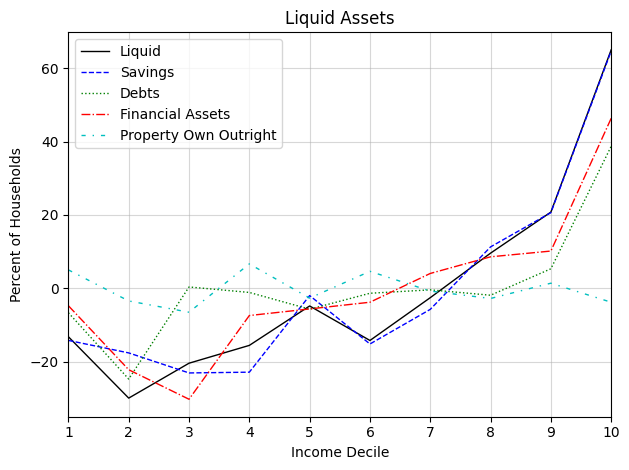

In [ ]:
by_decile = {}
to_by_decile = ['has_savings_formal_hh_resid', 'has_liquid_formal_hh_resid', 'has_loan_formal_hh_resid', 'has_financialassets_resid', 
                'property_own_outright_resid']
for measure in to_by_decile:
    by_decile[measure] =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh_resid', measure, 'weight')

deciles = np.arange(1, 11)
yticks = np.arange(0, 125, 25)

opt = {'linewidth':1}

plt.close()
fig= plt.figure()
ax1 = fig.add_subplot(111)

#ax.subplot(221)
ax1.plot(deciles, 100*by_decile['has_liquid_formal_hh_resid'], label='Liquid', **opt)
ax1.plot(deciles, 100*by_decile['has_savings_formal_hh_resid'], label='Savings', **opt)
ax1.plot(deciles, 100*by_decile['has_loan_formal_hh_resid'], label='Debts', **opt)
ax1.plot(deciles, 100*by_decile['has_financialassets_resid'], label='Financial Assets', **opt)
ax1.plot(deciles, 100*by_decile['property_own_outright_resid'], label='Property Own Outright', **opt)

ax1.set_xlabel('Income Decile')
ax1.set_ylabel('Percent of Households')
ax1.set_xticks(deciles)
#ax1.set_yticks(yticks)
ax1.set_title('Liquid Assets')

ax1.legend()
plt.show()

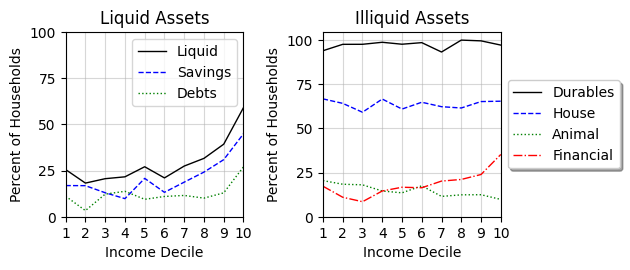

In [ ]:
import importlib
importlib.reload(utils)
deciles = np.arange(1, 11)
by_decile = {}
to_by_decile = ['has_savings_formal_hh', 'has_loan_formal_hh', 'has_liquid_formal_hh', 
                'has_savings_informal_hh', 'has_loan_informal_hh', 
                'has_housing', 'has_durable', 'has_animal', 'has_machinary',
                'has_illiquid_assets', 'has_productive_illiquid_assets',
                'has_financialassets', 'property_own_outright', 'property_own_community_ejido', 
                'net_saver_hh', 'net_borrower_hh', 'constrained_hh', 'has_liquid']
for measure in to_by_decile:
    by_decile[measure] =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh_resid', measure, 'weight')

deciles = np.arange(1, 11)
yticks = np.arange(0, 125, 25)

opt = {'linewidth':1}

fig= plt.figure()
ax1 = fig.add_subplot(221)

#ax.subplot(221)
ax1.plot(deciles, 100*by_decile['has_liquid_formal_hh'], label='Liquid', **opt)
ax1.plot(deciles, 100*by_decile['has_savings_formal_hh'], label='Savings', **opt)
ax1.plot(deciles, 100*by_decile['has_loan_formal_hh'], label='Debts', **opt)

ax1.set_xlabel('Income Decile')
ax1.set_ylabel('Percent of Households')
ax1.set_xticks(deciles)
ax1.set_yticks(yticks)
ax1.set_title('Liquid Assets')

ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(deciles, 100*by_decile['has_durable'], label='Durables', **opt)
ax2.plot(deciles, 100*by_decile['property_own_outright'], label='House', **opt)
ax2.plot(deciles, 100*by_decile['has_animal'], label='Animal', **opt)
#ax2.plot(deciles, 100*by_decile['has_machinary'], label='Machinary', **opt)
ax2.plot(deciles, 100*by_decile['has_financialassets'], label='Financial', **opt)
#ax2.plot(deciles, 100*by_decile['has_productive_illiquid_assets'], label='Productive', **opt)

ax2.set_xlabel('Income Decile')
ax2.set_ylabel('Percent of Households')
ax2.set_xticks(deciles)
ax2.set_yticks(yticks)
ax2.set_title('Illiquid Assets')

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.50),
          ncol=1, fancybox=True, shadow=True, fontsize=10)


os.chdir(figs)
plt.savefig('has_liquid_illiquid_by_income_decile.png')
plt.show()



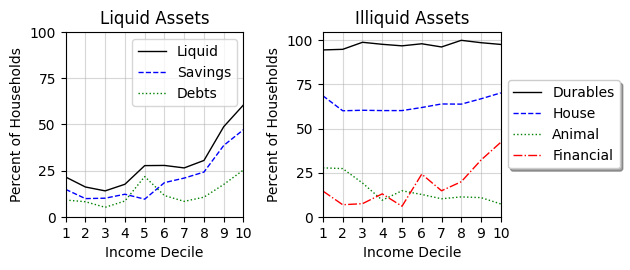

In [ ]:
import importlib
importlib.reload(utils)
deciles = np.arange(1, 11)
by_decile = {}
to_by_decile = ['has_savings_formal_hh', 'has_loan_formal_hh', 'has_liquid_formal_hh', 
                'has_savings_informal_hh', 'has_loan_informal_hh', 
                'has_housing', 'has_durable', 'has_animal', 'has_machinary',
                'has_illiquid_assets', 'has_productive_illiquid_assets',
                'has_financialassets', 'property_own_outright', 'property_own_community_ejido', 
                'net_saver_hh', 'net_borrower_hh', 'constrained_hh']
for measure in to_by_decile:
    by_decile[measure] =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh', measure, 'weight')

deciles = np.arange(1, 11)
yticks = np.arange(0, 125, 25)

opt = {'linewidth':1}

fig= plt.figure()
ax1 = fig.add_subplot(221)

#ax.subplot(221)
ax1.plot(deciles, 100*by_decile['has_liquid_formal_hh'], label='Liquid', **opt)
ax1.plot(deciles, 100*by_decile['has_savings_formal_hh'], label='Savings', **opt)
ax1.plot(deciles, 100*by_decile['has_loan_formal_hh'], label='Debts', **opt)

ax1.set_xlabel('Income Decile')
ax1.set_ylabel('Percent of Households')
ax1.set_xticks(deciles)
ax1.set_yticks(yticks)
ax1.set_title('Liquid Assets')

ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(deciles, 100*by_decile['has_durable'], label='Durables', **opt)
ax2.plot(deciles, 100*by_decile['property_own_outright'], label='House', **opt)
ax2.plot(deciles, 100*by_decile['has_animal'], label='Animal', **opt)
ax2.plot(deciles, 100*by_decile['has_financialassets'], label='Financial', **opt)
#ax2.plot(deciles, 100*by_decile['has_productive_illiquid_assets'], label='Productive', **opt)

ax2.set_xlabel('Income Decile')
ax2.set_ylabel('Percent of Households')
ax2.set_xticks(deciles)
ax2.set_yticks(yticks)
ax2.set_title('Illiquid Assets')

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax2.legend(loc='center left', bbox_to_anchor=(1.0, 0.50),
          ncol=1, fancybox=True, shadow=True, fontsize=10)

os.chdir(figs)
plt.savefig('has_liquid_illiquid_by_income_decile_unresidualized.png')
plt.show()


In [ ]:
#charges_interest_by_decile =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh_resid', 'loan_charges_interest_hh', 'weight')
#no_interest_by_decile =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh_resid', 'loan_no_interest_hh', 'weight')
#credit_card_by_decile =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh_resid', 'has_credit_card_hh', 'weight')

In [ ]:
#plt.clf()
#plt.plot(charges_interest_by_decile, label='Loan with Interest')
#plt.plot(credit_card_by_decile, label='Credit Card')
#plt.ylim(0, 0.50)
#plt.legend()
#plt.show()

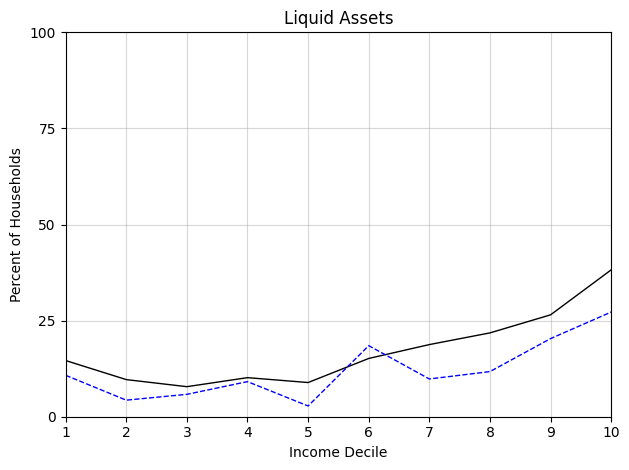

In [ ]:
to_ratio = ['savings_formal_hh', 'financialassets']
for x in to_ratio:
    df[x + '_20'] = df[x] / df['annual_labor_income_hh'] > 0.01

to_by_decile = ['savings_formal_hh_20', 'financialassets_20']
for measure in to_by_decile:
    by_decile[measure] =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh', measure, 'weight')

deciles = np.arange(1, 11)
yticks = np.arange(0, 125, 25)

opt = {'linewidth':1}

fig= plt.figure()
ax1 = fig.add_subplot(111)

#ax.subplot(221)
ax1.plot(deciles, 100*by_decile['savings_formal_hh_20'], label='Savings', **opt)
ax1.plot(deciles, 100*by_decile['financialassets_20'], label='Financial Assets', **opt)

ax1.set_xlabel('Income Decile')
ax1.set_ylabel('Percent of Households')
ax1.set_xticks(deciles)
ax1.set_yticks(yticks)
ax1.set_title('Liquid Assets')

plt.show()

<Figure size 640x480 with 0 Axes>

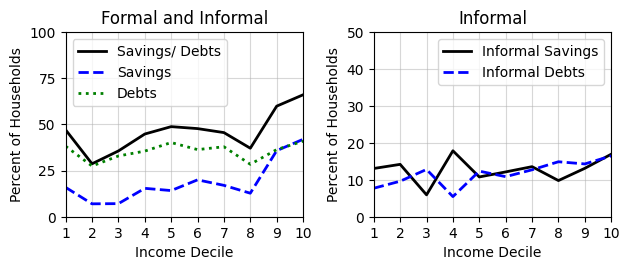

In [ ]:
deciles = np.arange(1, 11)
df['hh_has_savings_debts'] = df['hh_has_savings'] | df['hh_has_debts_12mth']
by_decile = {}
to_by_decile = ['hh_no_savings', 'hh_has_savings', 'hh_has_debts_12mth', 'hh_has_savings_debts']
for measure in to_by_decile:
    by_decile[measure] =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh', measure, 'weight')

deciles = np.arange(1, 11)
yticks = np.arange(0, 125, 25)

opt = {'linewidth':2}

plt.clf()
fig= plt.figure()
ax1 = fig.add_subplot(221)

#ax.subplot(221)
#ax1.plot(deciles, 100*by_decile['hh_no_savings'], label='No Savings', **opt)
ax1.plot(deciles, 100*by_decile['hh_has_savings_debts'], label='Savings/ Debts', **opt)
ax1.plot(deciles, 100*by_decile['hh_has_savings'], label='Savings', **opt)
ax1.plot(deciles, 100*by_decile['hh_has_debts_12mth'], label='Debts', **opt)

ax1.set_xlabel('Income Decile')
ax1.set_ylabel('Percent of Households')
ax1.set_xticks(deciles)
ax1.set_yticks(yticks)
ax1.set_title('Formal and Informal')

ax1.legend()

by_decile = {}
to_by_decile = ['has_savings_informal_hh', 'has_loan_informal_hh', 'has_productive_illiquid_assets', 
                'constrained_hh', 'net_saver_hh', 'net_borrower_hh']
for measure in to_by_decile:
    by_decile[measure] =  utils.indicator_by_decile(df, 'log_annual_labor_income_hh_resid', measure, 'weight')

deciles = np.arange(1, 11)

ax2 = fig.add_subplot(222)
ax2.plot(deciles, 100*by_decile['has_savings_informal_hh'], label='Informal Savings')
ax2.plot(deciles, 100*by_decile['has_loan_informal_hh'], label='Informal Debts')
ax2.set_xticks(deciles)
ax2.set_ylim(0, 50)

ax2.set_xlabel('Income Decile')
ax2.set_ylabel('Percent of Households')
ax2.set_title('Informal')

ax2.legend()

os.chdir(figs)
plt.savefig('has_informal_savings_debts_by_decile.png')
plt.show()


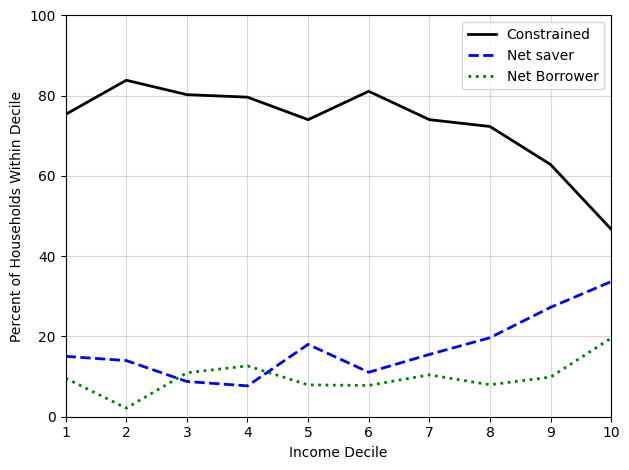

In [ ]:
deciles = np.arange(1, 11)

plt.clf()
plt.plot(deciles, 100 * by_decile['constrained_hh'], label='Constrained')
plt.plot(deciles, 100 * by_decile['net_saver_hh'], label='Net saver')
plt.plot(deciles, 100 * by_decile['net_borrower_hh'], label='Net Borrower')
plt.legend()

plt.xlabel('Income Decile')
plt.ylabel('Percent of Households Within Decile')
plt.ylim(0, 100)

plt.show()



<Figure size 640x480 with 0 Axes>

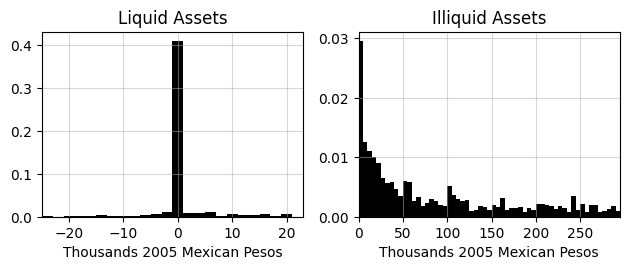

In [ ]:
plt.clf()
fig= plt.figure()

ax1 = fig.add_subplot(221)
liquid_bins = np.arange(start=-25, stop=25, step=2)
liquid_formal_hh_thousands = df['liquid_formal_hh'] / 1000
ax1.hist(liquid_formal_hh_thousands, bins=liquid_bins, weights=df['weight'], density=True)
ax1.set_title('Liquid Assets')
ax1.set_xlabel('Thousands 2005 Mexican Pesos')
ax1_ticks = ax1.get_xticks()
#ax1.set_xticklabels([x / 1000 for x in ax1_ticks])

illiquid_assets_thousands = df['illiquid_assets'] / 1000
ax2 = fig.add_subplot(222)
illiquid_bins = np.arange(start=0, stop=300, step=5)
ax2.hist(illiquid_assets_thousands, bins=illiquid_bins, weights=df['weight'], density=True)
ax2.set_title('Illiquid Assets')
ax2.set_xlabel('Thousands 2005 Mexican Pesos')
ax2_ticks = ax2.get_xticks()
#ax2.set_xticklabels([x / 1000 for x in ax2_ticks])
plt.show()

In [ ]:
import panel_distribution_utils as pdu
from tabulate import tabulate

In [ ]:
def shares(df, measure, metric, weight):
    x = df[measure].astype(float)
    x_metric = df[metric].astype(float)
    x_weight = df[weight].astype(float)
    share_top_05 = 1 - pdu.share(0.95, x, x_metric, x_weight )
    share_top_10 = 1 - pdu.share(0.90, x, x_metric, x_weight )
    share_bottom_50 = pdu.share(0.50, x, x_metric, x_weight )
    share_bottom_25 = pdu.share(0.25, x, x_metric, x_weight )
    #gini = pdu.gini(x, x_weight)

    return [share_top_05, share_top_10, share_bottom_50, share_bottom_25]

names =  ['share_top_05', 'share_top_10', 'share_bottom_50', 'share_bottom_25']
needs_stats = ['annual_labor_income_hh', 'liquid', 'net_wealth', 'savings_hh', 'financialassets', 'savings_formal_hh', 'productive_illiquid_assets', 'illiquid_assets']


 note: in its current form pdu does not seem able to handle negative values

In [ ]:
for x in needs_stats:
    stats_x = shares(df, x, 'log_annual_labor_income_hh_resid', 'weight')
    print()
    print(x.upper())
    print(tabulate({'Stat':names, 'Result':stats_x}))


ANNUAL_LABOR_INCOME_HH
---------------  ---------
share_top_05     0.245826
share_top_10     0.360237
share_bottom_50  0.20555
share_bottom_25  0.0674721
---------------  ---------

LIQUID
---------------  ---------
share_top_05     0.0279997
share_top_10     0.170926
share_bottom_50  0.48051
share_bottom_25  0.255059
---------------  ---------

NET_WEALTH
---------------  ---------
share_top_05     0.0735657
share_top_10     0.137873
share_bottom_50  0.575902
share_bottom_25  0.453996
---------------  ---------

SAVINGS_HH
---------------  --------
share_top_05     0.247004
share_top_10     0.348733
share_bottom_50  0.253848
share_bottom_25  0.139081
---------------  --------

FINANCIALASSETS
---------------  ---------
share_top_05     0.189107
share_top_10     0.397904
share_bottom_50  0.262724
share_bottom_25  0.0968625
---------------  ---------

SAVINGS_FORMAL_HH
---------------  --------
share_top_05     0.219435
share_top_10     0.332175
share_bottom_50  0.25588
share_bottom_25

claim: this measure of 'formal savings' seems to match the illiquid asset
does that mean the formal is valid?

claim: I need to residualize each of these based on observables such as age, sex, education

In [ ]:
for x in needs_stats:
    stats_x = shares(df, x, x, 'weight')
    print()
    print(x.upper())
    print(tabulate({'Stat':names, 'Result':stats_x}))


ANNUAL_LABOR_INCOME_HH
---------------  ---------
share_top_05     0.28938
share_top_10     0.407569
share_bottom_50  0.169591
share_bottom_25  0.0539871
---------------  ---------

LIQUID
---------------  ----------
share_top_05     -0.0932102
share_top_10     -0.100551
share_bottom_50   1.05689
share_bottom_25   0.963958
---------------  ----------

NET_WEALTH
---------------  -----------
share_top_05     0.504927
share_top_10     0.630155
share_bottom_50  0.0447441
share_bottom_25  0.000705583
---------------  -----------

SAVINGS_HH
---------------  --------
share_top_05     0.734263
share_top_10     0.875811
share_bottom_50  0
share_bottom_25  0
---------------  --------

FINANCIALASSETS
---------------  ---------
share_top_05     0.34529
share_top_10     0.523743
share_bottom_50  0.0808416
share_bottom_25  0.016568
---------------  ---------

SAVINGS_FORMAL_HH
---------------  --------
share_top_05     0.770655
share_top_10     0.941342
share_bottom_50  0
share_bottom_25  0
----

In [ ]:
def by_decile(df, measure, metric, weight):
    x = df[measure].astype(float)
    x_metric = df[metric].astype(float)
    x_weight = df[weight].astype(float)
    deciles = np.arange(0, 1.1, 0.1)

    decile_shares = np.array([pdu.share(decile, x, x_metric, x_weight) for decile in deciles])
    return np.diff(decile_shares)


In [ ]:
stats_by_decile = {}
needs_stats = ['savings_hh', 'illiquid_assets', 'house']
for stat in needs_stats:
    stats_by_decile[stat] = by_decile(df, stat, 'log_annual_labor_income_hh_resid', 'weight')
    print()
    print(stat.upper())
    print(tabulate({'Stat':np.arange(1, 11, 1), 'Result':stats_by_decile[stat]}))

    


SAVINGS_HH
--  ---------
 1  0.0395493
 2  0.0599996
 3  0.061868
 4  0.0210379
 5  0.071374
 6  0.0665169
 7  0.0815345
 8  0.0851576
 9  0.164209
10  0.348733
--  ---------

ILLIQUID_ASSETS
--  ---------
 1  0.171825
 2  0.0745535
 3  0.0714142
 4  0.0564253
 5  0.0710706
 6  0.0741306
 7  0.114371
 8  0.0858004
 9  0.124293
10  0.15604
--  ---------

HOUSE
--  ---------
 1  0.212149
 2  0.0586303
 3  0.0769952
 4  0.0560427
 5  0.0727158
 6  0.0694163
 7  0.107928
 8  0.091014
 9  0.121214
10  0.133895
--  ---------


KeyError: 'housing'

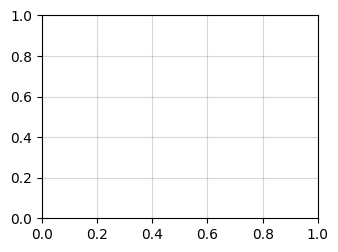

In [ ]:
deciles = np.arange(1, 11, 1)
plt.clf()
plt.subplot(221)
plt.plot(deciles, stats_by_decile['housing'])
plt.xlabel('Income Decile')
plt.ylabel('Share')

plt.title('housing')

plt.subplot(221)
plt.plot(deciles, stats_by_decile['illiquid_assets'])
plt.xlabel('Income Decile')
plt.ylabel('Share')
plt.title('Illiquid Assets')

plt.subplot(221)
plt.plot(deciles, stats_by_decile['savings_hh'])
plt.xlabel('Income Decile')
plt.ylabel('Share')

plt.title('Net Wealth')

In [ ]:
df['house'].value_counts()

housing
4.0    2036
6.0     506
2.0     404
Name: count, dtype: int64